## Example notebook of scoring a sentiment dataset with a LLM using langchain

In [1]:
import datasets
import pandas as pd
import json

In [2]:
from datasets import load_dataset

dataset = load_dataset(path='financial_phrasebank',name='sentences_allagree')

Found cached dataset financial_phrasebank (/Users/rajivshah/.cache/huggingface/datasets/financial_phrasebank/sentences_allagree/1.0.0/550bde12e6c30e2674da973a55f57edde5181d53f5a5a34c1531c53f93b7e141)


  0%|          | 0/1 [00:00<?, ?it/s]

In [30]:
data = dataset['train'].to_pandas()
data

,sentence,label
0,"According to Gran , the company has no plans t...",1
1,"For the last quarter of 2010 , Componenta 's n...",2
2,"In the third quarter of 2010 , net sales incre...",2
3,Operating profit rose to EUR 13.1 mn from EUR ...,2
4,"Operating profit totalled EUR 21.1 mn , up fro...",2
...,...,...
2259,Operating result for the 12-month period decre...,0
2260,HELSINKI Thomson Financial - Shares in Cargote...,0
2261,LONDON MarketWatch -- Share prices ended lower...,0
2262,Operating profit fell to EUR 35.4 mn from EUR ...,0


In [31]:
data_sample = data.sample(20)
data_sample

,sentence,label
2174,Subscription sales decreased slightly .,0
1106,The purchase sum is about EUR 10mn US$ 12.97 mn .,1
1838,The value of the deal was not disclosed .,1
1577,- The Group -¦ s profit before taxes was EUR 0...,1
601,The agreement is valid for four years .,1
2014,Finnair said that the cancellation of flights ...,0
182,Pretax profit rose to EUR 17.8 mn from EUR 14....,2
1301,N +1 Group will pay EUR16 .5 m of the transact...,1
1576,- The Group -¦ s cumulative sales during the r...,1
1259,"In total , more than 3000 surveillance cameras...",1


In [23]:
import os
import openai
os.environ["OPENAI_API_KEY"]="sk-"

In [24]:
from langchain.llms import OpenAI
llm = OpenAI(temperature=0.0)

In [7]:
PROMPT_TEMPLATE = """
Label the financial sentiment of the given text.

{sentence}

The answer should be exactly 'positive', 'negative', or 'neutral'. Return a JSON with the sentiment. Do not explain.
"""

In [8]:
from langchain.prompts import PromptTemplate
prompt = PromptTemplate(
        input_variables=["sentence"], template=PROMPT_TEMPLATE
    )
#prompt = PromptTemplate.from_template("Label the financial sentiment of the given text. {product} \n The answer should be exact 'positive', 'negative', or 'neutral'. The answer is")
#prompt.format(sentence=text1)

In [9]:
from langchain.chains import LLMChain

chain = LLMChain(llm=llm, prompt=prompt)
output = chain.run(data_sample['sentence'])
output

In [26]:
# Remove leading and trailing whitespace
data_string = output.strip()

# Convert the string to a DataFrame
output_df = pd.read_json(data_string, orient='index')
output_df = output_df.reset_index()
output_df.columns = ['ID', 'Sentiment']

print(output_df)

      ID Sentiment
0   2096  negative
1   1814   neutral
2    824   neutral
3    135  positive
4    954   neutral
5   1365   neutral
6   1136  positive
7    167  positive
8   1880  negative
9   1007  positive
10    23  positive
11  1839  positive
12  2221  positive
13   196  positive
14  1636   neutral
15   548   neutral
16  1711   neutral
17   688   neutral
18  1842   neutral
19  1927   neutral


In [27]:
sentiment_mapping = {
    'neutral': 1,
    'positive': 2,
    'negative': 0  # Optional, if you have 'negative' as a sentiment label
}

output_df['Sentiment'] = output_df['Sentiment'].replace(sentiment_mapping)

In [32]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Create the confusion matrix
cm = confusion_matrix( dff['label'],df['Sentiment'])
report = classification_report(data_sample['label'], output_df['Sentiment'])

print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(report)

Confusion Matrix:
[[2 0 1]
 [0 9 3]
 [0 1 4]]

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.33      0.40         3
           1       0.80      0.57      0.67        14
           2       0.25      0.67      0.36         3

    accuracy                           0.55        20
   macro avg       0.52      0.52      0.48        20
weighted avg       0.67      0.55      0.58        20



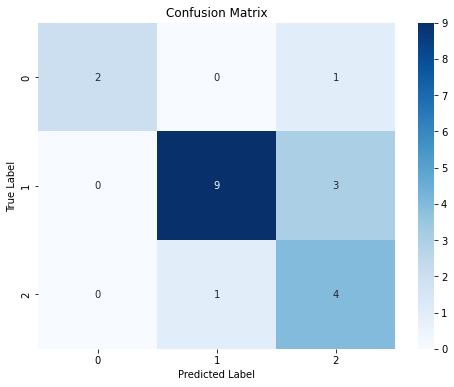

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# Set the class labels
class_labels = np.unique(np.concatenate((dff['label'], df['Sentiment'])))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()